In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import lite, keras
from tensorflow.keras import layers, backend
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    Add, GlobalAveragePooling2D, Dense, Dropout, Flatten
)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, array_to_img, img_to_array, load_img
)
from tensorflow.keras.callbacks import CSVLogger


In [5]:
os.listdir('../Data/')

['test', 'train']

In [6]:
base_dir = "../Data/train/"
image_paths = []
classes = []
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, image_file))
            classes.append(class_folder)

train = pd.DataFrame({'image': image_paths, 'class': classes})
train.head()

,image,class
0,../Data/train/CNV\CNV-1016042-1.jpeg,CNV
1,../Data/train/CNV\CNV-1016042-10.jpeg,CNV
2,../Data/train/CNV\CNV-1016042-100.jpeg,CNV
3,../Data/train/CNV\CNV-1016042-101.jpeg,CNV
4,../Data/train/CNV\CNV-1016042-102.jpeg,CNV


In [7]:
base_dir = "../Data/test/"
image_paths = []
classes = []
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, image_file))
            classes.append(class_folder)

test = pd.DataFrame({'image': image_paths, 'class': classes})
test.head()

,image,class
0,../Data/test/CNV\CNV-1032178-1.jpeg,CNV
1,../Data/test/CNV\CNV-1034361-1.jpeg,CNV
2,../Data/test/CNV\CNV-1034361-2.jpeg,CNV
3,../Data/test/CNV\CNV-1052341-1.jpeg,CNV
4,../Data/test/CNV\CNV-1106195-1.jpeg,CNV


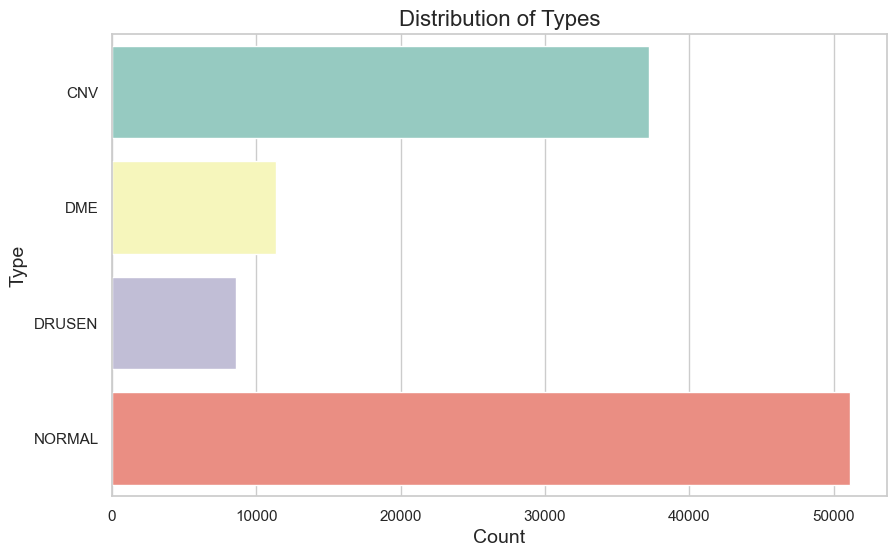

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='class', data=train, hue='class', palette="Set3")
plt.title('Distribution of Types', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.show()

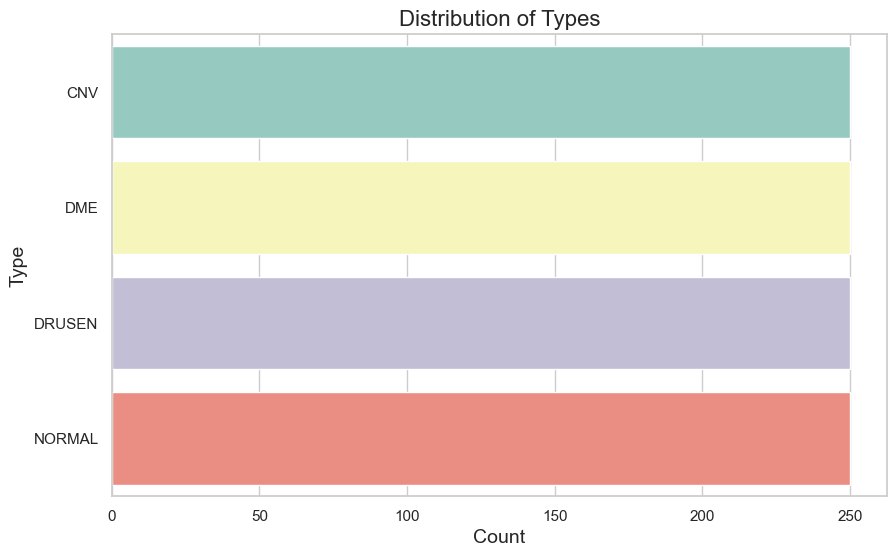

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='class', data=test, hue='class', palette="Set3")
plt.title('Distribution of Types', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.show()

In [10]:
train, valid = train_test_split(train, train_size=0.9, stratify=train['class'], random_state=0)

In [18]:
height = 512
width = 512
channels = 3
batch_size = 64
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test)

test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def scalar(img):
    img=img/255
    return img 

trgen=ImageDataGenerator(preprocessing_function=scalar, 
                         horizontal_flip=True, 
                         vertical_flip = True,
                         )
tvgen=ImageDataGenerator(preprocessing_function=scalar)


test_gen=tvgen.flow_from_dataframe( 
    test, 
    x_col='image', 
    y_col='class', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)
train_gen = trgen.flow_from_dataframe(
        train,
        x_col='image',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

valid_gen = tvgen.flow_from_dataframe(
        valid,
        x_col='image',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

test batch size:  50   test steps:  20
Found 1000 validated image filenames belonging to 4 classes.
Found 97478 validated image filenames belonging to 4 classes.
Found 10831 validated image filenames belonging to 4 classes.


In [19]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

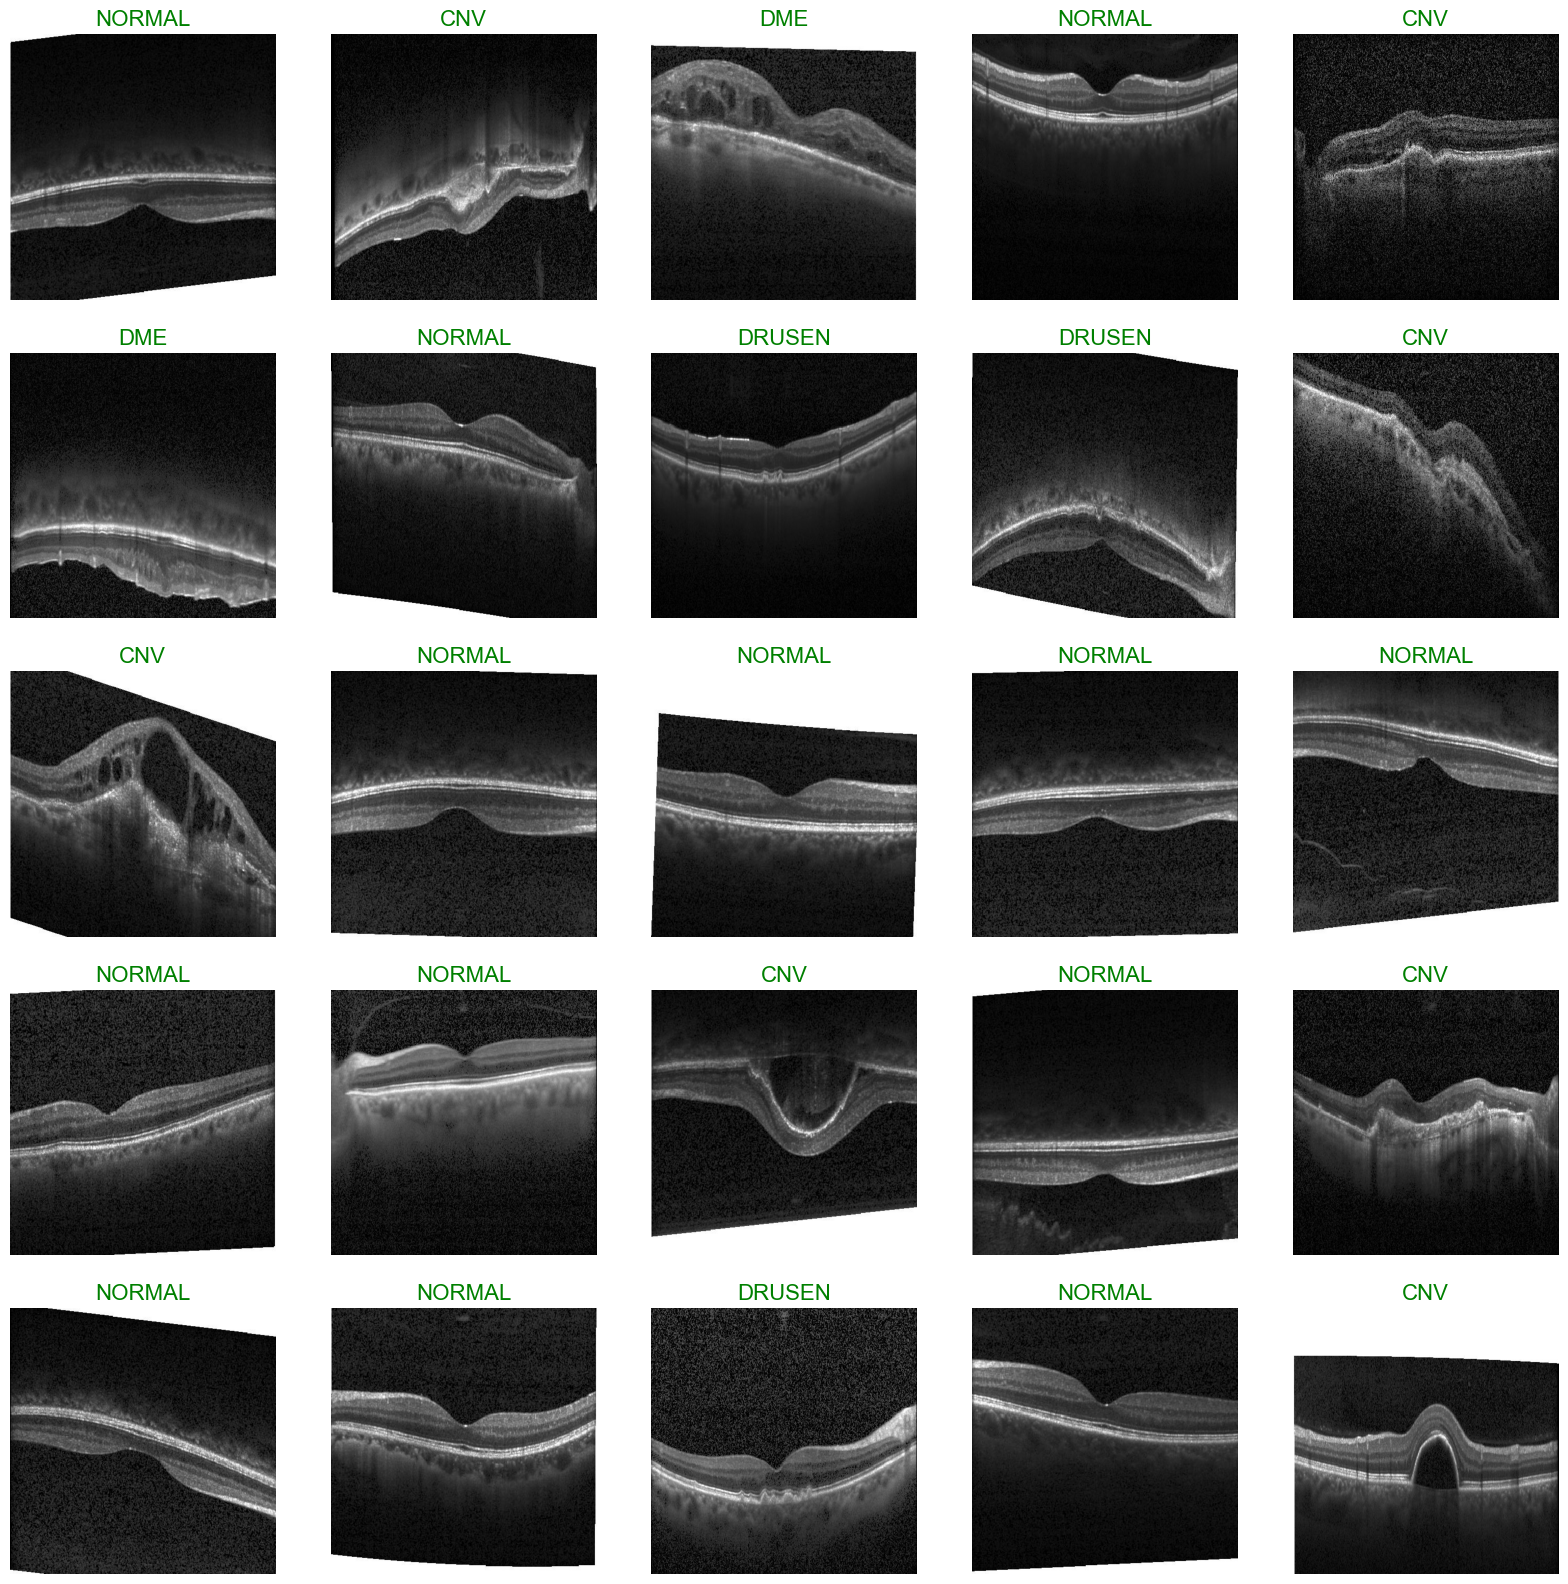

In [20]:
show_image_samples(train_gen)

In [21]:
def create_model(img_shape=(512,512, 3)):
    input_tensor = Input(shape=img_shape)
    base_model = tf.keras.applications.MobileNet(
        include_top=False,
        weights='imagenet', 
        input_tensor=input_tensor,  
        alpha=0.25
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3, seed=0)(x)
    output = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    return model

model = create_model()
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 8)       216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 256, 256, 8)      32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 256, 256, 8)       0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 8)      72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 256, 256, 8)      32        
 ation)                                                    

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-9)
early_stop = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

In [ ]:
epochs = 20
train_step = int(train_gen.samples/batch_size)
valid_step = int(valid_gen.samples/batch_size)

history = model.fit(
    x=train_gen,
    epochs=epochs,
    steps_per_epoch=train_step,  
    batch_size = batch_size,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=valid_step,
    shuffle=False,
    initial_epoch=0
)

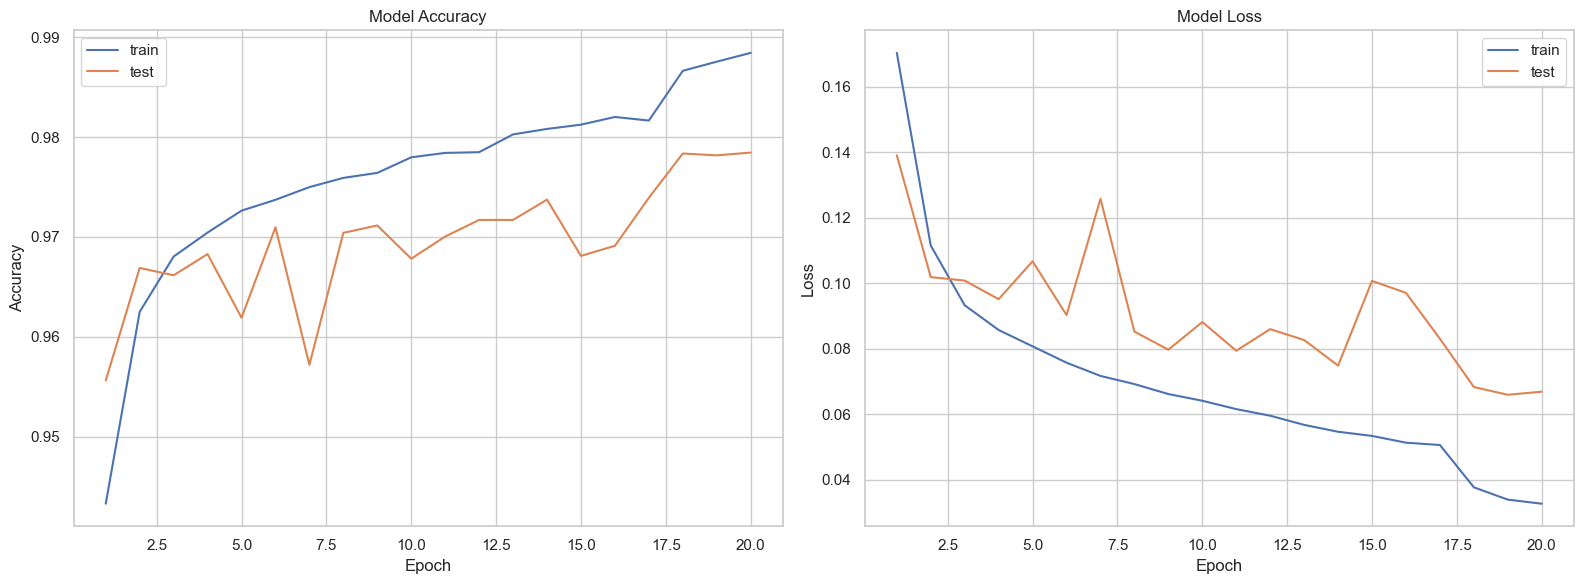

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
####################################
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], ax=axes[0], label='train')   
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], ax=axes[0], label='test')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')

sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], ax=axes[1], label='train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], ax=axes[1], label='test')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()
####################################

20/20 [==============================] - 36s 2s/step


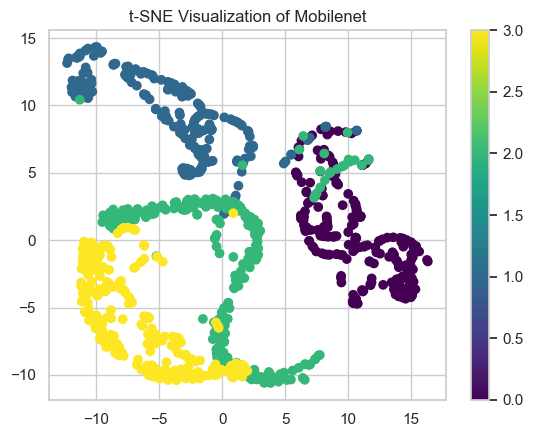

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

####################################
steps = len(test_gen)
features = model.predict(test_gen, steps=steps, verbose=1)
features_reshaped = features.reshape((features.shape[0], -1))
tsne = TSNE(n_components=3, random_state=0)
reduced_features = tsne.fit_transform(features_reshaped)
labels = np.concatenate([test_gen[i][1] for i in range(steps)])

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=np.argmax(labels, axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Mobilenet')
plt.show()

In [27]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key            
    classes=list(new_dict.values())     
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))              
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # Create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

20/20 [==============================] - 25s 1s/step
Classification Report:
----------------------
               precision    recall  f1-score   support

         CNV       0.84      0.99      0.91       250
         DME       0.98      0.96      0.97       250
      DRUSEN       0.99      0.84      0.91       250
      NORMAL       1.00      0.98      0.99       250

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.95      0.94      0.94      1000



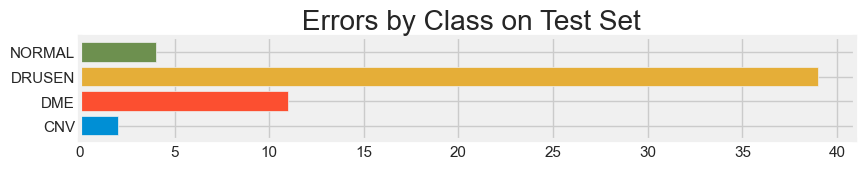

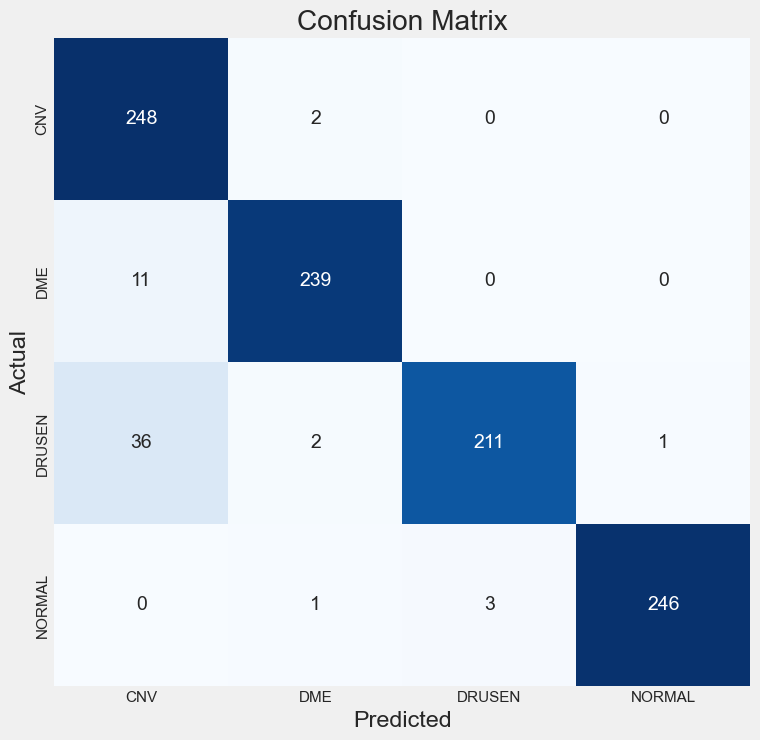

In [28]:
pred = model.predict(test_gen)
print_code = 0
save_dir = "./"
subject='classes'
print_info( test_gen, pred, print_code, save_dir, subject)